In [111]:
#testing git
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

my_data = np.load('B.npz')

bag_capacity = my_data['capacity']
n_items = my_data['n_items']
value_array = my_data["item_values"]
weight_array = my_data["item_weights"]

print(bag_capacity)
print(n_items)
print(value_array)
print(weight_array)

N_WEIGHTS = n_items
WEIGHTS = np.array(weight_array)
VALUES = np.array(value_array)

POP_SIZE = 600
DOFS_IN_POP = (POP_SIZE, N_WEIGHTS)
N_MATING = 500
N_OFFSPRING = 500
IDX_CROSSOVER = 25

curr_population = np.random.randint(2, size=DOFS_IN_POP)

149.0
50
[12. 14.  7. 15. 11.  8. 14. 14. 10. 10. 11. 13.  7. 10. 14. 10.  6.  6.
 10. 15. 11. 10.  7. 14. 10.  9. 11. 15. 15. 10. 13.  6. 11.  6. 15. 13.
 11.  8. 15.  6. 15.  8. 13. 12. 14.  8. 13.  8. 15.  9.]
[ 7  9  2 10  6  3  9  9  5  5  6  8  2  5  9  5  1  1  5 10  6  5  2  9
  5  4  6 10 10  5  8  1  6  1 10  8  6  3 10  1 10  3  8  7  9  3  8  3
 10  4]


In [112]:
def calc_fitness(t_pop):
    fitness = t_pop @ VALUES
    return fitness

In [113]:
def select_determinstic(t_pop, t_fitness):
    idx = np.argsort(t_fitness)
    idx = idx[::-1]
    parents = t_pop[idx]
    parents = parents[:N_MATING, :]
    return (parents, calc_fitness(parents))

In [114]:
def select_stochastic(t_pop, t_fitness):
    idx = np.argsort(t_fitness)
    r_i = np.empty_like(idx)
    r_i[idx] = np.arange(len(t_fitness))
    p_i = r_i + 2
    sum_pi = np.sum(p_i)
    q_i = p_i / sum_pi
    q_idx = np.argsort(q_i)
    q_i = q_i[q_idx]
    q_i = q_i[::-1]
    random_increment = 1./N_MATING
    random_val = np.random.rand(1, )
    arrow_locations = random_val + random_increment * np.arange(N_MATING)
    arrow_locations %= 1
    arrow_locations.sort()
    cum_qi = np.cumsum(q_i)
    zone_belong = np.searchsorted(cum_qi, arrow_locations)
    zone_belong = POP_SIZE - zone_belong - 1
    parents = t_pop[q_idx][zone_belong]
    par_fitness = t_fitness[q_idx][zone_belong]
    return (parents, par_fitness)

In [115]:
def crossover(t_parents):
    offspring = np.empty((N_OFFSPRING, N_WEIGHTS))
    for k in range(N_OFFSPRING):
        p1_idx = k%N_MATING
        p2_idx = (k+1)%N_MATING
        offspring[k, :IDX_CROSSOVER] = t_parents[p1_idx, :IDX_CROSSOVER]
        offspring[k, IDX_CROSSOVER:] = t_parents[p2_idx, IDX_CROSSOVER:]
    return (offspring, calc_fitness(offspring))

In [116]:
PM = 0.5
def mutation(t_offspring):
    random_mutator = np.random.uniform(0.0, 1.0, (N_OFFSPRING,))
    idx = random_mutator > PM
    nnz = np.count_nonzero(idx)
    mutated_offspring = t_offspring.copy()
    mutated_offspring[idx] = np.random.randint(2, size=n_items)
    return (mutated_offspring, calc_fitness(mutated_offspring))

In [117]:
LIMIT_WEIGHT = bag_capacity
def hard_constraint(t_total_pop):
    idx = []
    for candidate in t_total_pop:
        if candidate@WEIGHTS > LIMIT_WEIGHT:
            idx.append(False)
        else:
            idx.append(True)
    return t_total_pop[idx]

In [118]:
def environmental_selection(t_total_pop):
    tot_fitness = calc_fitness(t_total_pop)
    idx = np.argsort(tot_fitness)
    idx = idx[::-1]
    idx = idx[:POP_SIZE]
    return t_total_pop[idx]

In [119]:
best_outputs = []
num_generations = 1000
curr_population = np.zeros(DOFS_IN_POP)
overall_max_fitness = -99999

for generation in range(num_generations):
    print("Generation : ", generation)

    fitness = calc_fitness(curr_population)

    max_fitness = np.max(fitness)

    print("Best result in current iteration {0} compared to overall {1}".format(max_fitness, max(max_fitness, overall_max_fitness)))
    best_outputs.append(max_fitness)
    
    parents, _ = select_determinstic(curr_population, fitness)

    offspring_crossed, _ = crossover(parents)
    offspring_mutated, _ = mutation(offspring_crossed)
    
    total_population = np.vstack((curr_population, offspring_mutated))
    total_population = hard_constraint(total_population)

    curr_population = environmental_selection(total_population)
              
fitness = calc_fitness(curr_population)

max_idx = np.argmax(fitness)

print("Best solution : ", curr_population[max_idx, :])
print("Best solution fitness : ", fitness[max_idx])

Generation :  0
Best result in current iteration 0.0 compared to overall 0.0
Generation :  1
Best result in current iteration 195.0 compared to overall 195.0
Generation :  2
Best result in current iteration 221.0 compared to overall 221.0
Generation :  3
Best result in current iteration 279.0 compared to overall 279.0
Generation :  4
Best result in current iteration 286.0 compared to overall 286.0
Generation :  5
Best result in current iteration 286.0 compared to overall 286.0
Generation :  6
Best result in current iteration 286.0 compared to overall 286.0
Generation :  7
Best result in current iteration 286.0 compared to overall 286.0
Generation :  8
Best result in current iteration 286.0 compared to overall 286.0
Generation :  9
Best result in current iteration 286.0 compared to overall 286.0
Generation :  10
Best result in current iteration 286.0 compared to overall 286.0
Generation :  11
Best result in current iteration 286.0 compared to overall 286.0
Generation :  12
Best result i

<Figure size 864x864 with 0 Axes>

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Fitness')

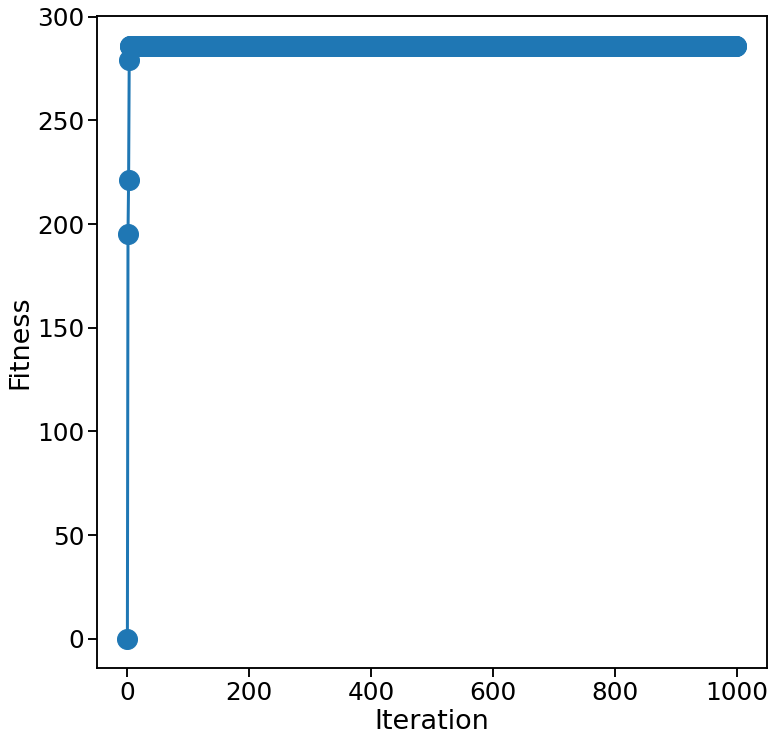

In [120]:
import pylab as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(best_outputs,'-o', lw=3, ms=20, label='from scratch')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.show()

<Figure size 864x864 with 0 Axes>

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Fitness')

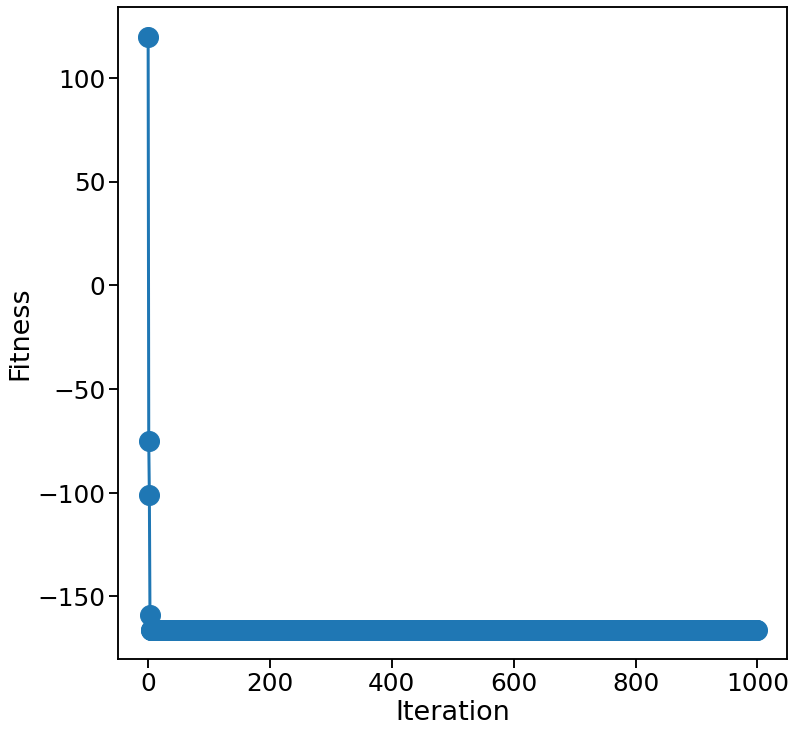

In [121]:
%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(120-np.array(best_outputs),'-o', lw=3, ms=20, label='from scratch')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.show()